# Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from geopy.distance import geodesic

# Generate random GPS data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from geopy.distance import geodesic
from sklearn.metrics import adjusted_rand_score


In [3]:
locations_df = pd.read_csv(r"C:\Users\maorb\CSVs\Locations.csv")
location_moment = pd.read_csv(r"C:\Users\maorb\CSVs\Location_momentum_data.csv")
synthetic_data = pd.read_csv(r"C:\Users\maorb\CSVs\Synthetic_data_markov_clusters.csv")
synth_last = pd.read_csv(r"C:\Users\maorb\CSVs\Synthetic_momentum_updated.csv")
geolife_red = pd.read_csv(r"C:\Users\maorb\CSVs\Geolife.csv")

C:\Users\maorb\AppData\Local\Temp\ipykernel_22868\2689771919.py:1: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  locations_df = pd.read_csv(r"C:\Users\maorb\CSVs\Locations.csv")


In [4]:
geolife_red.drop(columns=['date','altitude','time'],inplace=True)

In [4]:
import pandas as pd

# Step 1: Load the data
# Replace 'your_data.csv' with your actual data file path

# Step 2: Convert 'times' to datetime
geolife_red['datetime'] = pd.to_datetime(geolife_red['datetime'], errors='coerce')

# Step 3: Sort the data by 'uid' and 'times' in ascending order
df_sorted = geolife_red.sort_values(['user_id', 'datetime']).reset_index(drop=True)

# Step 4: Transform the data
transformed_rows = []
grouped = df_sorted.groupby('user_id')

for uid, group in grouped:
    group = group.reset_index(drop=True)
    for i in range(len(group) - 1):
        origin_row = group.loc[i]
        destination_row = group.loc[i + 1]
        
        new_row = {
            'start_time': origin_row['datetime'],
            'user_id': uid,
            'origin_lat': origin_row['latitude'],
            'origin_lon': origin_row['longitude'],
            'destination_lat': destination_row['latitude'],
            'destination_lon': destination_row['longitude'],
            'end_time': destination_row['datetime']
        }
        
        transformed_rows.append(new_row)

df_transformed = pd.DataFrame(transformed_rows)

# Step 5: Format the time columns
df_transformed['start_time'] = df_transformed['start_time'].dt.strftime('%m/%d/%Y %H:%M')
df_transformed['end_time'] = df_transformed['end_time'].dt.strftime('%m/%d/%Y %H:%M')

# Step 6: Review the transformed data
print(df_transformed.head())

# Step 7: Save the transformed data
df_transformed.to_csv(r"C:\Users\maorb\CSVs\Geolife_transformed.csv", index=False)


C:\Users\maorb\AppData\Local\Temp\ipykernel_22364\208601009.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  geolife_red['datetime'] = pd.to_datetime(geolife_red['datetime'], errors='coerce')


         start_time  user_id  origin_lat  origin_lon  destination_lat  \
0  10/23/2008 02:53        0   39.984683  116.318450        39.984686   
1  10/23/2008 02:53        0   39.984686  116.318417        39.984688   
2  10/23/2008 02:53        0   39.984688  116.318385        39.984655   
3  10/23/2008 02:53        0   39.984655  116.318263        39.984611   
4  10/23/2008 02:53        0   39.984611  116.318026        39.984608   

   destination_lon          end_time  
0       116.318417  10/23/2008 02:53  
1       116.318385  10/23/2008 02:53  
2       116.318263  10/23/2008 02:53  
3       116.318026  10/23/2008 02:53  
4       116.317761  10/23/2008 02:53  


In [6]:
def compute_origin_id(row, decimal_places=6):
    """
    Compute a consistent origin_id by rounding latitude and longitude.
    
    Args:
        row (pd.Series): A row from the DataFrame.
        decimal_places (int): Number of decimal places to round to.
    
    Returns:
        str: A string representing the origin_id.
    """
    lat = round(row['origin_lat'], decimal_places)
    lon = round(row['origin_lon'], decimal_places)
    return f"{lat}_{lon}"

import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two sets of lat/lon coordinates.
    Args:
        lat1, lon1: Latitude and longitude of the first point
        lat2, lon2: Latitude and longitude of the second point
    Returns:
        Distance in kilometers
    """
    # Earth radius in kilometers
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    return distance

def preprocess_and_calculate_speed(df):
    """
    This function preprocesses the DataFrame by renaming columns, removing missing data, 
    filtering, and calculating speed based on the distance and time difference.

    Args:
        df (pd.DataFrame): The original DataFrame containing movement data.

    Returns:
        pd.DataFrame: The processed DataFrame with additional columns for speed.
    """
    df = df.copy()
    # Drop unnecessary column, remove NaNs, and rename columns
    for col in df.columns:
        if col in ['Unnamed: 17', 'Unnamed: 18','RecordedAtTime', 'PublishedLineName', 'OriginLat', 'OriginLong', 
             'DestinationLat', 'DestinationLong', 'ExpectedArrivalTime']:
            df.drop(columns=['Unnamed: 17'], inplace=True, errors='ignore')  # In case Unnamed: 17 exists
            df = df.dropna()  # Drop rows with missing values
            df = df[['RecordedAtTime', 'PublishedLineName', 'OriginLat', 'OriginLong', 
                    'DestinationLat', 'DestinationLong', 'ExpectedArrivalTime']]

            # Rename columns
            df = df.rename(columns={'RecordedAtTime': 'start_time', 
                                    'PublishedLineName': 'user_id', 
                                    'OriginLat': 'origin_lat', 
                                    'OriginLong': 'origin_lon', 
                                    'DestinationLat': 'destination_lat', 
                                    'DestinationLong': 'destination_lon', 
                                    'ExpectedArrivalTime': 'end_time'})

    # Convert to datetime
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce') #, format='%m/%d/%Y %H:%M')
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce') #, format='%m/%d/%Y %H:%M')

    # Calculate time difference
    df['diff'] = df['end_time'] - df['start_time']

    # Filter rows with time difference larger than 5 seconds
    #df = df[df['diff'] > pd.Timedelta('00:00:02')]

    # Remove letters from user_id and keep only numeric part
    #df['user_id'] = df['user_id'].str.extract('(\d+)')

    # Calculate distance and speed
    df['distance_km'] = haversine_distance(df['origin_lat'], df['origin_lon'], df['destination_lat'], df['destination_lon'])
    df['time_hours'] = df['diff'].dt.total_seconds() / 3600.0
    df['time_hours'] = df['time_hours'].replace(0, 1e-6)  # Prevent division by zero
    df['speed'] = df['distance_km'] / df['time_hours']
    #decimal_places = 4
    #df['origin_id'] = df.apply(lambda row: compute_origin_id(row, decimal_places), axis=1)

    return df


In [94]:
def assign_trip_indicators(df, distance_threshold=0.1, time_threshold_minutes=1):
    """
    Assign 'O', 'M', 'D' indicators for trips and update origin_id.
    
    Args:
        df (pd.DataFrame): DataFrame containing movement data.
        distance_threshold (float): Distance in meters to consider still at Origin.
        time_threshold_minutes (float): Maximum time in minutes to consider between movements.
    
    Returns:
        pd.DataFrame: Updated DataFrame with 'trip_indicator' and updated 'origin_id'.
    """
    df = df.copy()
    df['trip_indicator'] = ''
    df['origin_id'] = ''
    
    for user_id in df['user_id'].unique():
        print(f"Processing user {user_id}")

        user_data = df[df['user_id'] == user_id]
        origin_lat = user_data['origin_lat'].iloc[0]
        origin_lon = user_data['origin_lon'].iloc[0]
        origin_id = compute_origin_id({'origin_lat': origin_lat, 'origin_lon': origin_lon})
        df.loc[user_data.index[0], 'trip_indicator'] = 'O'
        df.loc[user_data.index[0], 'origin_id'] = origin_id
        for i in range(1, len(user_data)):
            print(f"Processing row {i}")
            #prev_row = user_data.loc[i - 1]
            curr_row = user_data.iloc[i]
            #print(curr_row) 
            
            # Calculate distance from Origin
            distance_from_origin = curr_row['distance_km']
            
            # Calculate time difference from previous movement
            time_diff = curr_row['diff'].total_seconds() / 60  # in minutes
            print(time_diff)
            
            if (distance_from_origin <= distance_threshold) or (time_diff <= time_threshold_minutes):
                # Still within the same trip
                df.loc[user_data.index[i], 'trip_indicator'] = 'M'
                df.loc[user_data.index[i], 'origin_id'] = origin_id
            else:
                # Movement to a new destination
                df.loc[user_data.index[i - 1], 'trip_indicator'] = 'D'  # Mark previous as Destination
                # Start new trip
                origin_lat = curr_row['origin_lat']
                origin_lon = curr_row['origin_lon']
                origin_id = compute_origin_id({'origin_lat': origin_lat, 'origin_lon': origin_lon})
                df.loc[user_data.index[i], 'trip_indicator'] = 'O'
                df.loc[user_data.index[i], 'origin_id'] = origin_id
        
        # Mark the last movement as 'D' if not already set
        if df.loc[user_data.index[-1], 'trip_indicator'] != 'D':
            df.loc[user_data.index[-1], 'trip_indicator'] = 'D'
    
    return df


In [73]:
locations_df_new2 = preprocess_and_calculate_speed(df_transformed)


In [ ]:
locations_df_new2_assigned = assign_trip_indicators(locations_df_new2)

In [4]:
#value_caount for each user_id
locations_df_new2_assigned = pd.read_csv(r"C:\Users\maorb\CSVs\Geolife_transformed_assigned.csv")

In [5]:
locations_df_new2_assigned_subset = locations_df_new2_assigned.groupby('user_id').head(600)

In [6]:
len(locations_df_new2_assigned_subset)  

57276

# `Model`

In [511]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import logging


"""
░▒▓█▓▒░░▒▓█▓▒░▒▓████████▓▒░▒▓█▓▒░      ░▒▓███████▓▒░░▒▓████████▓▒░▒▓███████▓▒░         
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓████████▓▒░▒▓██████▓▒░ ░▒▓█▓▒░      ░▒▓███████▓▒░░▒▓██████▓▒░ ░▒▓███████▓▒░         
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒░░▒▓█▓▒░▒▓████████▓▒░▒▓████████▓▒░▒▓█▓▒░      ░▒▓████████▓▒░▒▓█▓▒░░▒▓█▓▒░                                                                                                                                                                                   
"""

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)






"""
╔╦╗┬┬─┐┌─┐┌─┐┌┬┐┬┌─┐┌┐┌
 ║║│├┬┘├┤ │   │ ││ ││││:
═╩╝┴┴└─└─┘└─┘ ┴ ┴└─┘┘└┘

"""

def determine_direction(origin, destination):
    """
    Determine movement direction based on latitude and longitude differences.
    
    Args:
        origin (tuple): (latitude, longitude) of the origin.
        destination (tuple): (latitude, longitude) of the destination.
    
    Returns:
        str: Direction string.
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1

    # Determine direction based on latitude and longitude differences
    if delta_lat > 0 and delta_lon > 0:
        return 'North-East'
    elif delta_lat > 0 and delta_lon < 0:
        return 'North-West'
    elif delta_lat < 0 and delta_lon > 0:
        return 'South-East'
    elif delta_lat < 0 and delta_lon < 0:
        return 'South-West'
    elif delta_lat == 0 and delta_lon > 0:
        return 'East'
    elif delta_lat == 0 and delta_lon < 0:
        return 'West'
    elif delta_lat > 0 and delta_lon == 0:
        return 'North'
    elif delta_lat < 0 and delta_lon == 0:
        return 'South'
    else:
        return 'Undefined'
    

"""
╔═╗┌─┐┌┬┐┌─┐┌─┐┌─┐┬─┐┬┌─┐┌─┐
║  ├─┤ │ ├┤ │ ┬│ │├┬┘│┌─┘├┤ :
╚═╝┴ ┴ ┴ └─┘└─┘└─┘┴└─┴└─┘└─┘

"""

def categorize_speed(speed, speed_thresholds):
    """
    Categorize speed into Low, Medium, or High based on thresholds.
    
    Args:
        speed (float): Speed value.
        speed_thresholds (dict): Dictionary with 'low' and 'medium' speed thresholds.
    
    Returns:
        str: Speed category.
    """
    # Categorize speed based on thresholds
    if speed <= speed_thresholds['low']:
        return 'Low'
    elif speed <= speed_thresholds['medium']:
        return 'Medium'
    else:
        return 'High'
    

"""
╔╦╗┬┌─┐┌─┐┬  ┌─┐┌─┐┌─┐┌┬┐┌─┐┌┐┌┌┬┐
 ║║│└─┐├─┘│  ├─┤│  ├┤ │││├┤ │││ │ :
═╩╝┴└─┘┴  ┴─┘┴ ┴└─┘└─┘┴ ┴└─┘┘└┘ ┴ 

"""

def compute_displacement_type(df, speed_thresholds, decimal_places=4):
    """
    Compute displacement type and origin_id for each movement.
    
    Args:
        df ->(pd.DataFrame): DataFrame containing Main data
        speed_thresholds ->(dict): Dictionary with 'low' and 'medium' speed thresholds.
        decimal_places ->(int): Number of decimal places to round coordinates to.
    
    Returns:
        pd.DataFrame: Updated DataFrame with 'speed_level', 'direction', 'displacement_type', and 'origin_id'.
    """
    df = df.copy()
    df['speed_level'] = df['speed'].apply(lambda x: categorize_speed(x, speed_thresholds))
    df['direction'] = df.apply(lambda row: determine_direction(
        (row['origin_lat'], row['origin_lon']),
        (row['destination_lat'], row['destination_lon'])
    ), axis=1)
    # For low speed, direction is not considered
    df['displacement_type'] = df.apply(
        lambda row: row['speed_level'] + '_' + row['direction'] if row['speed_level'] != 'Low' else 'Low',
        axis=1
    )
    # Compute consistent origin_id
    #df['origin_id'] = df.apply(lambda row: compute_origin_id(row, decimal_places), axis=1)
    return df




"""
╦┌┐┌┬┌┬┐┬┌─┐┬  ┬┌─┐┌─┐
║││││ │ │├─┤│  │┌─┘├┤ :
╩┘└┘┴ ┴ ┴┴ ┴┴─┘┴└─┘└─┘

"""

def initialize_cluster_counts(num_clusters):
    """
    Initialize counts for each cluster.
    
    Args:
        num_clusters -> (int): Number of clusters.
    
    Returns:
        dict: Initialized clusters dictionary.
    """
    clusters = {}
    for k in range(num_clusters):
        clusters[k] = {
            'n_d_o': {},        # Counts of transitions from origin to destination
            'n_tau_o': {},      # Counts of time intervals from origin
            'n_tot_o': {}     # Total counts from each origin
        }
    return clusters


"""

╦ ╦┌─┐┌┬┐┌─┐┌┬┐┌─┐
║ ║├─┘ ││├─┤ │ ├┤ :
╚═╝┴  ─┴┘┴ ┴ ┴ └─┘
                  
"""
def update_cluster_counts(clusters, k, user_data, increment=True, bin_size=60):
    """
    Update cluster counts when a user is added or removed from a cluster.
    
    Args:
        clusters (dict): Clusters dictionary.
        k (int): Cluster ID.
        user_data (pd.DataFrame): DataFrame containing user movement data.
        increment (bool): Whether to add (True) or remove (False) counts.
        bin_size (int): Size of each time bin in seconds.
    """
    factor = 1 if increment else -1
    user_data = user_data.copy()

    # Filter transitions where trip_indicator is 'M' and displacement_type is not 'Undefined'
  
    if user_data.empty:
        return  # No valid transitions to update

    # Aggregate counts per origin_id and displacement_type
    displacement_counts = user_data.groupby(['origin_id', 'displacement_type']).size().reset_index(name='count')
    
    # Aggregate counts per origin_id and time_interval
    #user_data['destination_id'] = user_data['origin_id'].shift(-1)
    user_data['time_interval_binned'] = user_data['time_interval_seconds'].apply(lambda x: bin_time_interval(x, bin_size=bin_size))
    time_interval_counts = user_data.groupby(['origin_id', 'time_interval_binned']).size().reset_index(name='count')
    #Change to using loc


    # Update n_d_o
    for _, row in displacement_counts.iterrows():
        origin_id = row['origin_id']
        #destination_id = row['destination_id']
        displacement_type = row['displacement_type']
        count = row['count']
        
        if origin_id not in clusters[k]['n_d_o']:
            clusters[k]['n_d_o'][origin_id] = {}
            #clusters[k]['n_ud_o'][origin_id] = {}
        if displacement_type not in clusters[k]['n_d_o'][origin_id]:
            clusters[k]['n_d_o'][origin_id][displacement_type] = 0
        #if destination_id not in clusters[k]['n_d_o'][origin_id]:
         #   clusters[k]['n_ud_o'][origin_id][destination_id] = 0
        clusters[k]['n_d_o'][origin_id][displacement_type] += factor * count
        #clusters[k]['n_ud_o'][origin_id][destination_id] += factor * count

    # Update n_tau_o
    for _, row in time_interval_counts.iterrows():
        origin_id = row['origin_id']
        time_interval = row['time_interval_binned']
        count = row['count']
        
        if origin_id not in clusters[k]['n_tau_o']:
            clusters[k]['n_tau_o'][origin_id] = {}
        if time_interval not in clusters[k]['n_tau_o'][origin_id]:
            clusters[k]['n_tau_o'][origin_id][time_interval] = 0
        clusters[k]['n_tau_o'][origin_id][time_interval] += factor * count

    # Update n_tot_o
    total_counts = user_data.groupby('origin_id').size().to_dict()
    for origin_id, count in total_counts.items():
        if origin_id not in clusters[k]['n_tot_o']:
            clusters[k]['n_tot_o'][origin_id] = 0
        clusters[k]['n_tot_o'][origin_id] += factor * count




"""
╔╦╗┬─┐┌─┐┌┐┌┌─┐┬┌┬┐┬┌─┐┌┐┌  ╔═╗┌─┐┬ ┬┌┐┌┌┬┐┌─┐
 ║ ├┬┘├─┤│││└─┐│ │ ││ ││││  ║  │ ││ ││││ │ └─┐: 
 ╩ ┴└─┴ ┴┘└┘└─┘┴ ┴ ┴└─┘┘└┘  ╚═╝└─┘└─┘┘└┘ ┴ └─┘

"""

def clean_clusters(clusters,cluster_assignments,df):
    """
    Remove origin_ids from clusters where counts are zero.

    Args:
        clusters (dict): Clusters dictionary.

    Returns:
        dict: Cleaned clusters dictionary.
    """

    df = df.copy()
    df['clusters'] = df['user_id'].map(cluster_assignments)
    origin_id_cluster = df.groupby('origin_id')['clusters'].apply(list).to_dict()


    for k in clusters:
        # Clean n_d_o, n_tau_o, and n_tot_o
        n_tot_o = clusters[k]['n_tot_o']
        n_tau_o = clusters[k]['n_tau_o']
        n_d_o = clusters[k]['n_d_o']
        origin_ids_to_remove = []
        for origin_id in list(n_d_o.keys()):
            if origin_id not in origin_id_cluster:
                origin_ids_to_remove.append(origin_id)
            displacement_counts = n_d_o[origin_id]
            # Remove displacement_types with zero counts
            displacement_types_to_remove = [dt for dt, count in displacement_counts.items() if count <= 0]
            for dt in displacement_types_to_remove:
                del displacement_counts[dt]
            # If after removing zero-count displacement_types, the displacement_counts dict is empty, mark origin_id for removal
            if not displacement_counts:
                origin_ids_to_remove.append(origin_id)
        # Remove origin_ids with empty displacement_counts
        for origin_id in origin_ids_to_remove:
            del n_d_o[origin_id]
            del n_tau_o[origin_id] 
            del n_tot_o[origin_id]
            
    return clusters





"""

 ░▒▓██████▓▒░░▒▓█▓▒░▒▓███████▓▒░░▒▓███████▓▒░ ░▒▓███████▓▒░       ░▒▓██████▓▒░░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░░▒▓███████▓▒░▒▓████████▓▒░▒▓████████▓▒░▒▓███████▓▒░         
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░             ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░         ░▒▓█▓▒░   ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒░      ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░             ░▒▓█▓▒░      ░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░         ░▒▓█▓▒░   ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒▒▓███▓▒░▒▓█▓▒░▒▓███████▓▒░░▒▓███████▓▒░ ░▒▓██████▓▒░       ░▒▓█▓▒░      ░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░░▒▓██████▓▒░   ░▒▓█▓▒░   ░▒▓██████▓▒░ ░▒▓███████▓▒░         
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░      ░▒▓█▓▒░  ░▒▓█▓▒░   ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░      ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░     ░▒▓█▓▒░░▒▓█▓▒░      ░▒▓█▓▒░  ░▒▓█▓▒░   ░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓██▓▒░ 
 ░▒▓██████▓▒░░▒▓█▓▒░▒▓███████▓▒░░▒▓███████▓▒░░▒▓███████▓▒░        ░▒▓██████▓▒░░▒▓████████▓▒░▒▓██████▓▒░░▒▓███████▓▒░   ░▒▓█▓▒░   ░▒▓████████▓▒░▒▓█▓▒░░▒▓█▓▒░        
                                                                                                                                                                                                                                                                                                                                                                                                                             
"""

def gibbs_sampling_over_time(df, num_clusters, num_iterations, gamma, alpha, beta, speed_thresholds, 
                             delta_time_hours=1, decimal_places=4, distance_threshold=100, 
                             time_threshold_minutes=1):
    """
    Perform Gibbs sampling over iterations to assign clusters to users.

    Args:
        df (pd.DataFrame): DataFrame containing movement data.
        num_clusters (int): Number of clusters.
        num_iterations (int): Number of Gibbs sampling iterations.
        gamma (float): Smoothing parameter.
        alpha (float): Hyperparameter for prior.
        beta (float): Hyperparameter for prior.
        speed_thresholds (dict): Speed thresholds for categorization.
        delta_time_hours (int): Time interval in hours for clustering.
        decimal_places (int): Decimal places for rounding coordinates.
        distance_threshold (float): Distance in meters to consider still at Origin.
        time_threshold_minutes (float): Maximum time gap in minutes between movements.

    Returns:
        dict: Cluster assignments mapping user_id to cluster_id.
        pd.DataFrame: Processed DataFrame.
        list: List of vocabulary sizes per cluster per user.
        dict: Final cluster counts.
    """
    # Initialize lists to store log-likelihoods and priors (optional for analysis)
    L_list = []
    log_p = []
    log_lik = []
    cluster_sizes_over_iterations = []
    aris = []
    # Define the complete list of displacement types globally
    displacement_list = [
        'High_North-West', 'High_North-East', 'High_South-East', 'High_South-West', 
        'Medium_North-West', 'Medium_North-East', 'Medium_South-West', 'Medium_South-East',
        'Low', 'High_West', 'High_East', 'High_North', 'High_South', 
        'Medium_West', 'Medium_East', 'Medium_North', 'Medium_South'
    ]
    
    # Compute displacement types
    df = compute_displacement_type(df, speed_thresholds, decimal_places)

    # Ensure 'start_time' and 'end_time' are in datetime format
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')  # Convert to datetime
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

    # Drop rows with invalid datetime entries
    df.dropna(subset=['start_time', 'end_time'], inplace=True)

    # Sort data by time
    df = df.sort_values('start_time')
    #df['destination_id'] = df['origin_id'].shift(-1)
    # Define time intervals (e.g., every hour)
    df['time_interval'] = df['start_time'].dt.floor(f'{delta_time_hours}H')  # e.g., floor to nearest hour

    # Compute time interval seconds for each row
    df['time_interval_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds()  # In seconds


    # Initialize clusters
    
    clusters = initialize_cluster_counts(num_clusters)

    
    #L_fixed = len(displacement_list)  # Fixed vocabulary size. implemented different L for each origin_id

    # Initialize cluster assignments before iterations
    cluster_assignments = {}  # user_id -> cluster_id
    previous_cluster_assignments = {}  # user_id -> cluster_id at previous time
    k_new = np.random.choice(num_clusters)
    user_ids = df['user_id'].unique()
    for user_id in user_ids:
        k = np.random.choice(num_clusters)
        cluster_assignments[user_id] = k
        user_data = df[df['user_id'] == user_id]
        if not user_data.empty and (user_data['displacement_type'] != 'Undefined').any():
            update_cluster_counts(clusters, k, user_data, increment=True)
    previous_cluster_assignments = cluster_assignments.copy()
    # Perform Gibbs Sampling iterations
    for iteration in range(num_iterations):
        logger.info(f"Starting Gibbs Sampling Iteration {iteration + 1}/{num_iterations}")

        sorted_users = df.groupby('user_id')['start_time'].min().sort_values().index.tolist()

        for user_id in sorted_users:
            user_data = df[df['user_id'] == user_id]
            user_data = user_data.copy()
            if user_data.empty:
                continue

            k_old = cluster_assignments[user_id]


            if (user_data['displacement_type'] != 'Undefined').any():
                update_cluster_counts(clusters, k_old, user_data, increment=False)

            log_likelihoods = []
            log_priors = []
            for k in range(num_clusters):
                log_likelihood = 0.0
                    


                if not user_data.empty:
                    displacement_counts = user_data.groupby(['origin_id', 'displacement_type']).size().reset_index(name='displacement_count')
                    user_data['time_interval_binned'] = user_data['time_interval_seconds'].apply(lambda x: bin_time_interval(x, bin_size=60))
                    time_interval_counts = user_data.groupby(['origin_id', 'time_interval_binned']).size().reset_index(name='interval_count')
                    displacement_counts = displacement_counts.merge(time_interval_counts, on='origin_id', how='left')
                    displacement_counts = displacement_counts[displacement_counts['time_interval_binned'] == 60] #maybe should return

                    for _, row in displacement_counts.iterrows():
                        origin_id = row['origin_id']
                        displacement_type = row['displacement_type']
                        displacement_count = row['displacement_count']

                        
                        if origin_id not in clusters[k]['n_d_o']:
                            continue


                        cluster_numerator = displacement_count + gamma
                        L = len(user_data[(user_data['origin_id'] == origin_id) & (user_data['trip_indicator'] == 'M')])
                        if L == 0:
                            L = 1
                        L_list.append(L)
                        cluster_denominator = displacement_counts['displacement_count'].sum() + L * gamma
                        print(f"cluster_numerator: {cluster_numerator}, cluster_denominator: {cluster_denominator}")
                        if cluster_denominator == 0:
                            logger.warning(f"Denominator zero for cluster {k}, origin_id {origin_id}.")
                            prob = 1e-10
                        else:
                            prob = cluster_numerator / cluster_denominator
                        log_lik.append(prob)
                        prob = max(prob, 1e-10)

                        log_likelihood += displacement_count * np.log(prob)

                log_likelihoods.append(log_likelihood)

                # Calculate prior
                n_total_t_minus_u = len(cluster_assignments) - 1
                n_k_t_minus_u = sum(1 for uid, ck in cluster_assignments.items() if ck == k and uid != user_id)

                n_total_t_minus_1 = len(previous_cluster_assignments)
                n_k_t_minus_1 = sum(1 for uid, ck in previous_cluster_assignments.items() if ck == k)

                numerator_prior = n_k_t_minus_u + alpha * n_k_t_minus_1 + beta
                denominator_prior = n_total_t_minus_u + alpha * n_total_t_minus_1 + beta * num_clusters

                prior = numerator_prior / denominator_prior if denominator_prior != 0 else 1.0 / num_clusters
                log_p.append(prior)
                prior = max(prior, 1e-10)
                log_priors.append(np.log(prior))

            # Calculate log-posterior
            log_posterior = np.array(log_likelihoods) + np.array(log_priors)
            log_posterior -= np.max(log_posterior)  # Numerical stability

            posterior_probs = np.exp(log_posterior)
            posterior_probs /= posterior_probs.sum()

            # Sample new cluster
            k_new = np.random.choice(num_clusters, p=posterior_probs)
            cluster_assignments[user_id] = k_new
            
            # Update cluster counts
            if (user_data['displacement_type'] != 'Undefined').any():
                update_cluster_counts(clusters, k_new, user_data, increment=True)
                for _, row in displacement_counts.iterrows():
                    origin_id = row['origin_id']
                    displacement_type = row['displacement_type']
                    displacement_count = row['displacement_count']
                    time_interval = row['time_interval_binned']
                    time_interval_count = row['time_interval_binned']
                    clusters[k_new]['n_d_o'][origin_id][displacement_type] = displacement_count
                    clusters[k_new]['n_tot_o'][origin_id] = sum(clusters[k_new]['n_d_o'][origin_id].values())
                    clusters[k_new]['n_tau_o'][origin_id][time_interval] = time_interval_count
        cluster_sizes = [sum(1 for c in cluster_assignments.values() if c == k) for k in range(num_clusters)]
        cluster_sizes_over_iterations.append(cluster_sizes)
        labels_prev = [previous_cluster_assignments[user_id] for user_id in sorted_users]
        labels_curr = [cluster_assignments[user_id] for user_id in sorted_users]
        ari = adjusted_rand_score(labels_prev, labels_curr)
        aris.append(ari)
        previous_cluster_assignments = cluster_assignments.copy()
        logger.info(f"Completed Gibbs Sampling Iteration {iteration + 1}/{num_iterations}")

    return cluster_assignments, df, L_list, clusters, log_lik, log_p, cluster_sizes_over_iterations, aris




def bin_time_interval(seconds, bin_size=60):
    """
    Bin the time interval into buckets.
    
    Args:
        seconds (int): Time interval in seconds.
        bin_size (int): Size of each bin in seconds.
    
    Returns:
        int: Binned time interval.
    """
    return (seconds // bin_size) * bin_size


"""

░▒▓███████▓▒░░▒▓███████▓▒░░▒▓████████▓▒░▒▓███████▓▒░░▒▓█▓▒░░▒▓██████▓▒░▒▓████████▓▒░▒▓█▓▒░░▒▓██████▓▒░░▒▓███████▓▒░  
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ ░▒▓█▓▒░   ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ 
░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░        ░▒▓█▓▒░   ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ 
░▒▓███████▓▒░░▒▓███████▓▒░░▒▓██████▓▒░ ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░        ░▒▓█▓▒░   ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ :
░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░        ░▒▓█▓▒░   ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ 
░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ ░▒▓█▓▒░   ░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░▒▓█▓▒░░▒▓█▓▒░ 
░▒▓█▓▒░      ░▒▓█▓▒░░▒▓█▓▒░▒▓████████▓▒░▒▓███████▓▒░░▒▓█▓▒░░▒▓██████▓▒░  ░▒▓█▓▒░   ░▒▓█▓▒░░▒▓██████▓▒░░▒▓█▓▒░░▒▓█▓▒░ 
                                                                                                                     
"""                                                                                                                     

import pandas as pd
import numpy as np
from datetime import timedelta
import logging

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


import numpy as np
import pandas as pd
from datetime import timedelta
import logging

def predict_future_movements_binned(
    df,
    cluster_assignments,
    clusters,
    delta_t_hours=1,
    decimal_places=4,
    area_bounds=None,  # Tuple: (min_lat, max_lat, min_lon, max_lon)
    prediction_start_time=None,
    prediction_end_time=None
):
    """
    Predict future movements for each user based on their cluster transitions with binned time intervals,
    within a specified geographical area and time window.

    Args:
        df (pd.DataFrame): DataFrame containing movement data.
        cluster_assignments (dict): Cluster assignments mapping user_id to cluster_id.
        clusters (dict): Transition counts per cluster.
        delta_t_hours (int): Time window for predictions into the future.
        decimal_places (int): Decimal places for rounding coordinates.
        area_bounds (tuple, optional): Geographical boundaries as (min_lat, max_lat, min_lon, max_lon).
        prediction_start_time (pd.Timestamp, optional): Start time for predictions.
        prediction_end_time (pd.Timestamp, optional): End time for predictions.

    Returns:
        pd.DataFrame: Predicted movements with columns ['user_id', 'predicted_time', 'predicted_lat', 'predicted_lon'].
    """

    predicted_movements = []

    # Ensure 'start_time' and 'end_time' are datetime
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

    # Compute 'destination_id' by shifting 'origin_id' within each user
    df['destination_id'] = df.groupby('user_id')['origin_id'].shift(-1)

    # Drop rows with invalid datetime entries or missing 'destination_id'
    df = df.dropna(subset=['start_time', 'end_time', 'destination_id']).copy()

    

    # Apply area filtering if bounds are provided
    if area_bounds is not None:
        min_lat, max_lat, min_lon, max_lon = area_bounds
        df = df[
            (df['origin_lat'] >= min_lat) & (df['origin_lat'] <= max_lat) &
            (df['origin_lon'] >= min_lon) & (df['origin_lon'] <= max_lon) &
            (df['destination_lat'] >= min_lat) & (df['destination_lat'] <= max_lat) &
            (df['destination_lon'] >= min_lon) & (df['destination_lon'] <= max_lon)
        ]
        logger.info(f"Area filtered data: {len(df)} rows")

    # Apply time window filtering if provided
    if prediction_start_time is not None:
        df = df[df['end_time'] >= prediction_start_time]
    if prediction_end_time is not None:
        df = df[df['end_time'] <= prediction_end_time]
    logger.info(f"Time filtered data: {len(df)} rows")

    df['cluster_id'] = df['user_id'].map(cluster_assignments)
    # Build mapping from origin_id to (lat, lon)
    origin_id_to_location = df.groupby('origin_id').agg({'origin_lat': 'mean', 'origin_lon': 'mean'})

    # Set the prediction time window
    delta_t = timedelta(hours=delta_t_hours)

    for user_id in df['user_id'].unique():
        user_cluster = cluster_assignments.get(user_id)
        if user_cluster is None:
            continue  # Skip if user not in cluster assignments

        # Get user's data and last location within the filtered data
        user_data = df[df['user_id'] == user_id].sort_values('start_time')
        logger.info(f"Predicting movements for user {user_id} in cluster {user_cluster} with {len(user_data)} movements.")
        if user_data.empty:
            continue

        last_movement = user_data.iloc[-1]
        hat_O = last_movement['origin_id']
        hat_tau = last_movement['end_time']

        # Set the end time for predictions
        t_end = hat_tau + delta_t

        while hat_tau < t_end:
            cluster = clusters.get(user_cluster, {})
            df_cluster = df[df['cluster_id'] == user_cluster]
            if not cluster:
                logger.warning(f"No data for cluster {user_cluster}")
                break  # No data for this cluster

            # Get transition counts from current origin
            n_d_o = df_cluster[df_cluster['trip_indicator'] == 'D']['origin_id'].value_counts()
            n_tau_o = cluster['n_tau_o'].get(hat_O, {})
            n_tot_o = cluster['n_tot_o'].get(hat_O, 0)

            if n_tot_o == 0  or not n_tau_o:
                # Cannot proceed further
                break

            # Compute probabilities for destinations
            dest_ids = n_d_o.keys() #list(n_d_o.keys())
            dest_counts = n_d_o.values #list(n_d_o.values())
            dest_probs = dest_counts / dest_counts.sum()

            if len(dest_ids) == 0 or len(dest_probs) == 0:
                logger.warning(f"No destination probabilities for cluster {user_cluster}, origin {hat_O}")
                break    
            # Draw next location
            hat_D = np.random.choice(dest_ids, p=dest_probs)

            # Compute probabilities for time intervals
            tau_values = list(n_tau_o.keys())
            tau_counts = np.array([n_tau_o[tau] for tau in tau_values])
            tau_probs = tau_counts / tau_counts.sum()

            # Draw next time interval
            delta_hat_tau = np.random.choice(tau_values, p=tau_probs)
            delta_hat_tau = int(delta_hat_tau)  # Ensure integer

            # Update time
            hat_tau += timedelta(seconds=delta_hat_tau)

            # Update origin
            hat_O = hat_D

            # Get location of new origin_id
            if hat_O not in origin_id_to_location.index:
                logger.warning(f"Cannot find location for origin {hat_O}")
                # Cannot find location, stop prediction
                break

            location = origin_id_to_location.loc[hat_O]
            predicted_lat = location['origin_lat']
            predicted_lon = location['origin_lon']

            # Record predicted movement
            predicted_movements.append({
                'user_id': user_id,
                'predicted_time': hat_tau,
                'predicted_lat': predicted_lat,
                'predicted_lon': predicted_lon
            })

    # Convert predictions to DataFrame
    predicted_df = pd.DataFrame(predicted_movements)
    return predicted_df


In [592]:
# Example parameters
speed_thresholds = {'low': 10.8, 'medium': 43.2}
num_clusters = 6
num_iterations = 3
gamma = 0.1
alpha = 1
beta = 1000
delta_time_hours = 1  # Time interval for Gibbs sampling
prediction_delta_hours = 36  # Prediction horizon

 
    
# Perform Gibbs sampling over time
cluster_assignments, processd_df,L_list, clusters2,log_lik, log_p, clusters_over_time, aris = gibbs_sampling_over_time(
    locations_df_new2_assigned_subset,#locations_df_new2[:10000],
    num_clusters=num_clusters,
    num_iterations=num_iterations,
    gamma=gamma,
    alpha=alpha,
    beta=beta,
    speed_thresholds=speed_thresholds,
    delta_time_hours=delta_time_hours,
    decimal_places=4
)
    






INFO:__main__:Starting Gibbs Sampling Iteration 1/3


cluster_numerator: 1.1, cluster_denominator: 56.2
cluster_numerator: 2.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 56.2
cluster_numerator: 4.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denominator: 57.5
cluster_numerator: 4.1, cluster_denominator: 57.5
cluster_numerator: 14.1, cluster_denominator: 57.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 1.1, cluster_denominator: 55.5
cluster_numerator: 5.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 1.1, cluster_denominator: 3.1
cluster_numerator: 2.1, cluster_denominator: 3.1
cluster_numerator: 1.1, cluster_denominator: 28.4
cluster_numerator: 4.1, cluster_denominator: 28.4
cluster_numerator: 8.1, cluster_denominator: 28.4
c

INFO:__main__:Completed Gibbs Sampling Iteration 1/3
INFO:__main__:Starting Gibbs Sampling Iteration 2/3


cluster_numerator: 1.1, cluster_denominator: 61.4
cluster_numerator: 31.1, cluster_denominator: 61.4
cluster_numerator: 5.1, cluster_denominator: 61.4
cluster_numerator: 9.1, cluster_denominator: 61.4
cluster_numerator: 6.1, cluster_denominator: 61.4
cluster_numerator: 4.1, cluster_denominator: 61.4
cluster_numerator: 3.1, cluster_denominator: 187.9
cluster_numerator: 7.1, cluster_denominator: 187.9
cluster_numerator: 66.1, cluster_denominator: 187.9
cluster_numerator: 6.1, cluster_denominator: 187.9
cluster_numerator: 63.1, cluster_denominator: 187.9
cluster_numerator: 4.1, cluster_denominator: 187.9
cluster_numerator: 22.1, cluster_denominator: 187.9
cluster_numerator: 1.1, cluster_denominator: 56.2
cluster_numerator: 2.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 56.2
cluster_numerator: 4.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denomin

INFO:__main__:Completed Gibbs Sampling Iteration 2/3
INFO:__main__:Starting Gibbs Sampling Iteration 3/3


cluster_numerator: 1.1, cluster_denominator: 56.2
cluster_numerator: 2.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 56.2
cluster_numerator: 4.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denominator: 57.5
cluster_numerator: 1.1, cluster_denominator: 57.5
cluster_numerator: 4.1, cluster_denominator: 57.5
cluster_numerator: 14.1, cluster_denominator: 57.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 1.1, cluster_denominator: 55.5
cluster_numerator: 5.1, cluster_denominator: 55.5
cluster_numerator: 2.1, cluster_denominator: 55.5
cluster_numerator: 1.1, cluster_denominator: 56.2
cluster_numerator: 2.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 56.2
cluster_numerator: 4.1, cluster_denominator: 56.2
cluster_numerator: 7.1, cluster_denominator: 57.5

INFO:__main__:Completed Gibbs Sampling Iteration 3/3


In [529]:
clusters_over_time = pd.read_csv(r"C:\Users\maorb\CSVs\CityMomentum_Clusters.csv")

## Graphing the chains of number of user for each cluster over time

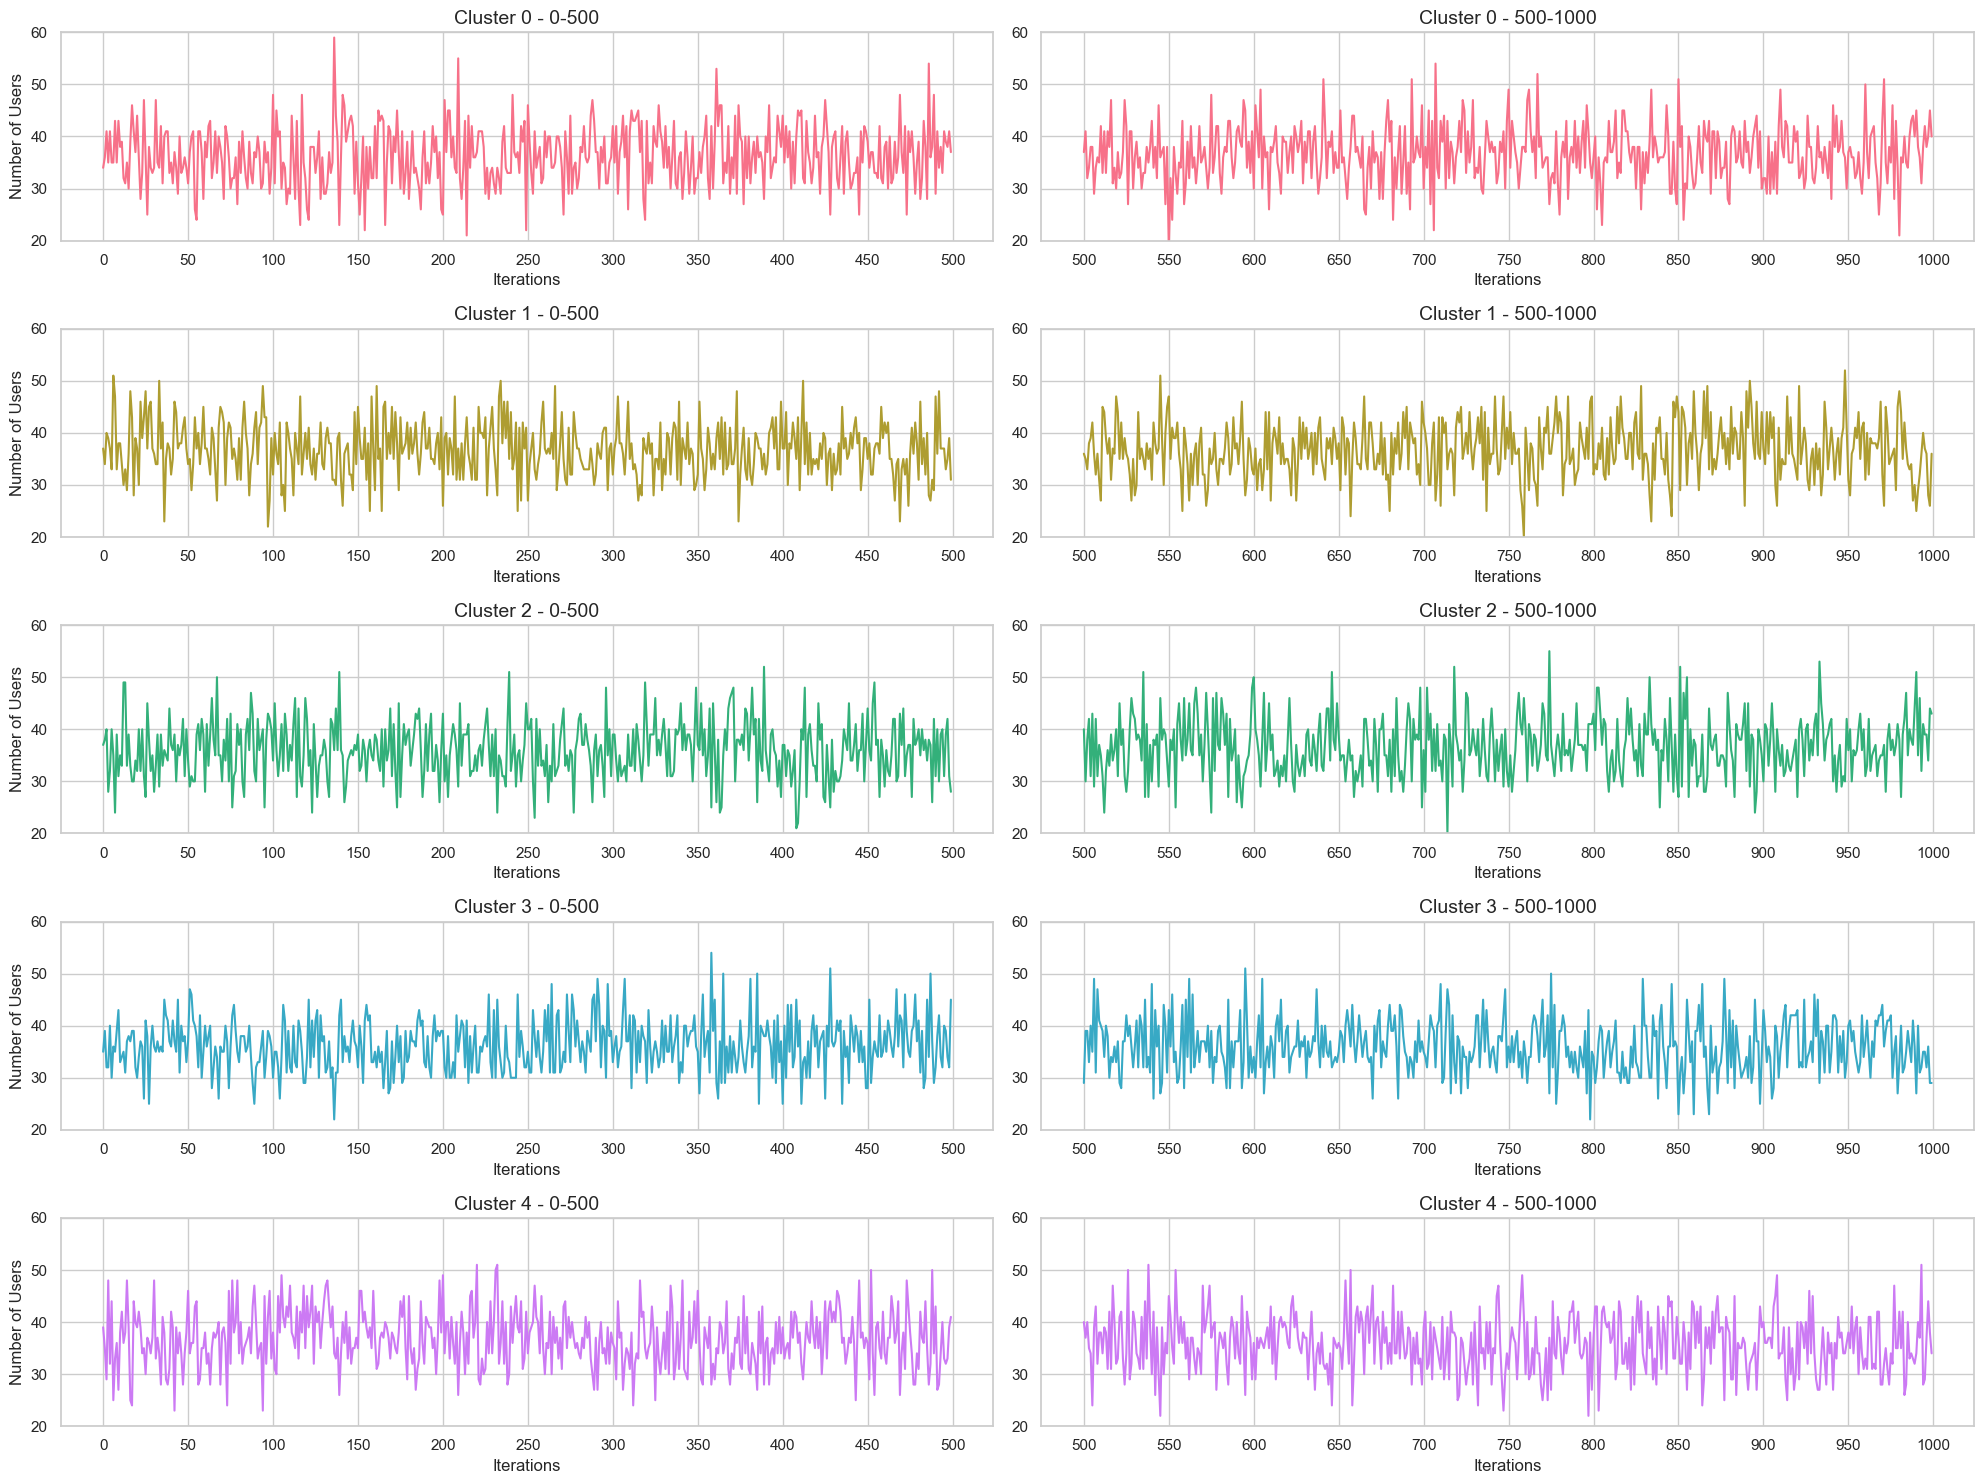

In [547]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd

# Suppress warnings
warnings.filterwarnings("ignore")

# Example Data Preparation (Replace this with your actual data)


def plot_clusters_side_by_side(clusters_over_time, num_clusters, range1, range2, range1_label, range2_label):
    """
    Plots two segments of cluster data side by side for comparison.

    Parameters:
    - clusters_over_time: 2D numpy array or pandas DataFrame of shape (iterations, clusters)
    - num_clusters: int, number of clusters
    - range1: tuple, (start, end) for the first segment
    - range2: tuple, (start, end) for the second segment
    - range1_label: str, label for the first segment
    - range2_label: str, label for the second segment
    """
    # Set the aesthetic style of the plots
    sns.set(style="whitegrid")

    # Define the subplot grid: num_clusters rows and 2 columns
    fig, axes = plt.subplots(num_clusters, 2, figsize=(20, num_clusters * 3), sharex=False)

    # Define a list of colors (optional)
    colors = sns.color_palette("husl", num_clusters)  # Unique color per cluster

    for i in range(num_clusters):
        for j, (range_tuple, label) in enumerate(zip([range2, range1], [range2_label, range1_label])):
            ax = axes[i, j]  # Access the specific subplot

            # Extract the relevant slice for the current range
            start, end = range_tuple
            clutch_30 = clusters_over_time[start:end, i]

            x_values = range(start, end)


            sns.lineplot(x=x_values, y=clutch_30, ax=ax, color=colors[i], label=f'Cluster {i}')

            # Set title and labels
            ax.set_title(f'Cluster {i} - {label}', fontsize=14)
            ax.set_xlabel('Iterations', fontsize=12)
            if j == 0:
                ax.set_ylabel('Number of Users', fontsize=12)
            else:
                ax.set_ylabel('')  # Remove y-axis label for second column

            ax.set_ylim(20, 60)

            # Customize y-ticks only for first column
            if j == 0:
                ax.set_yticks([20, 30, 40, 50, 60])  # Set y-ticks for first column

            # Customize x-ticks
            ax.set_xticks(range(start, end + 1, 50))

            ax.legend().remove()

    # Adjust layout to prevent overlap
    plt.tight_layout()

    plt.show()


range1 =  (500, 1000)  
range2 =  (0, 500)  
range1_label = "500-1000"
range2_label = "0-500"

plot_clusters_side_by_side(clusters_over_time.values, num_clusters, range1, range2, range1_label, range2_label)


## Autocorrelation for each cluster

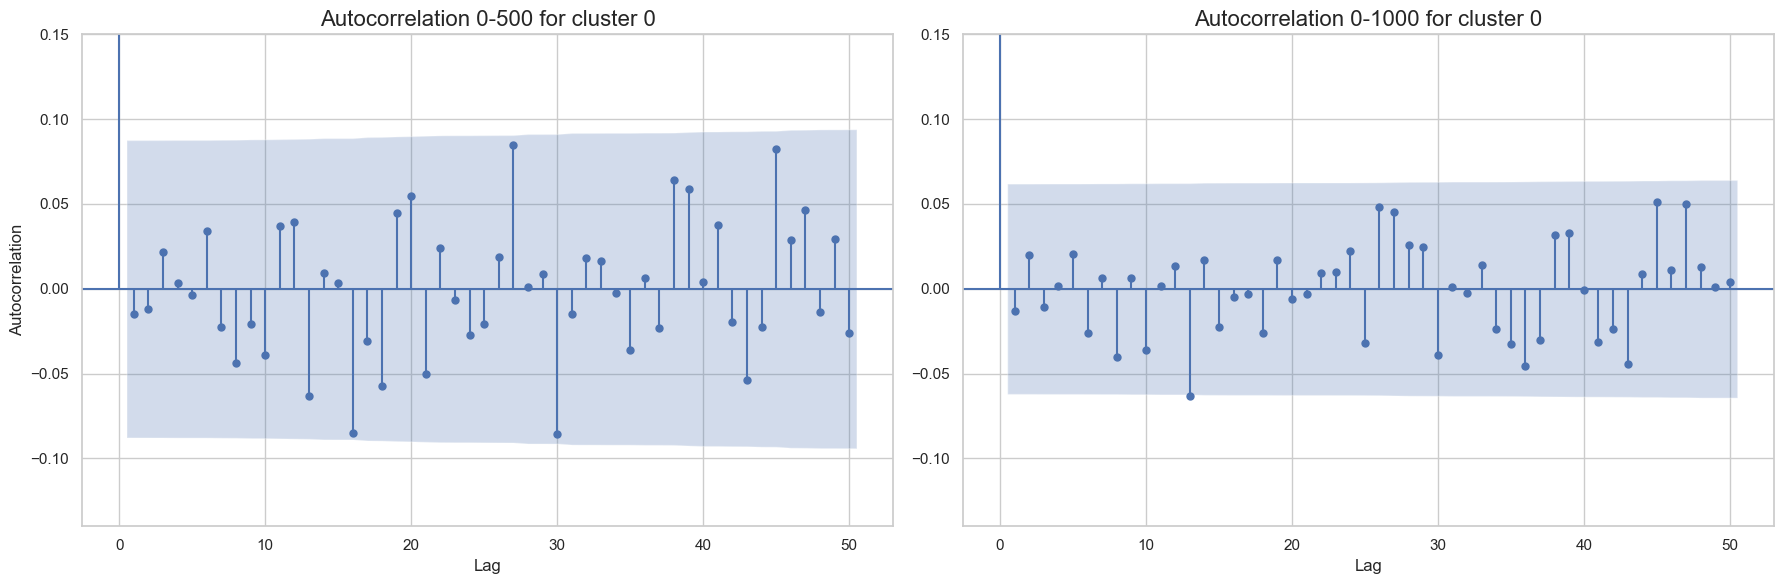

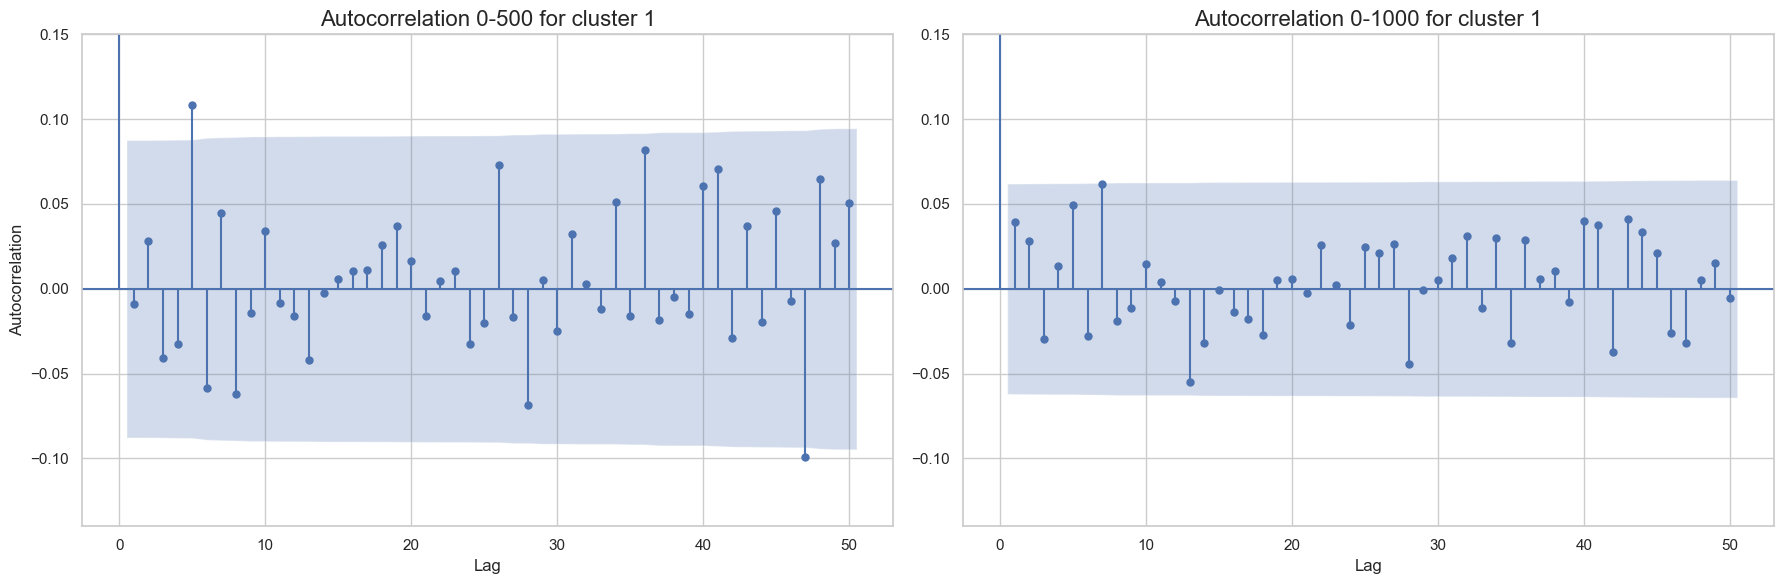

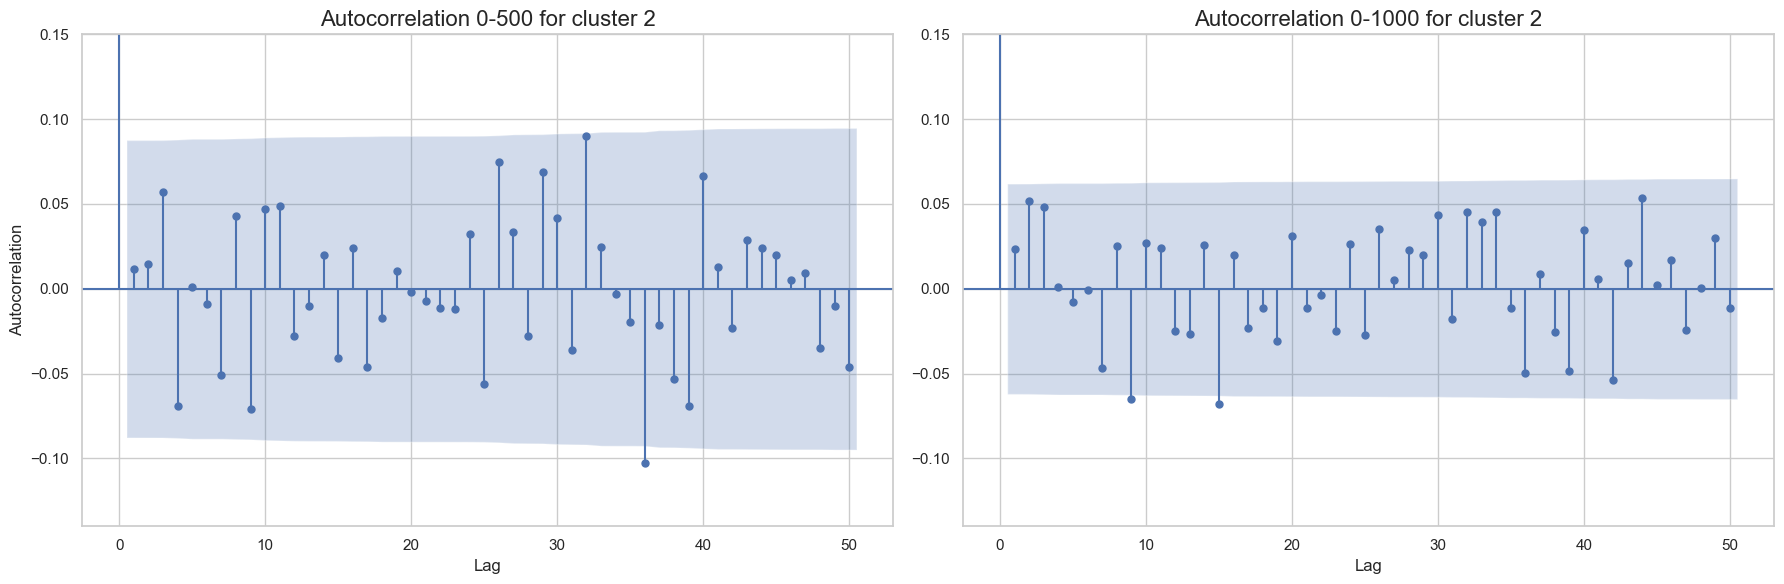

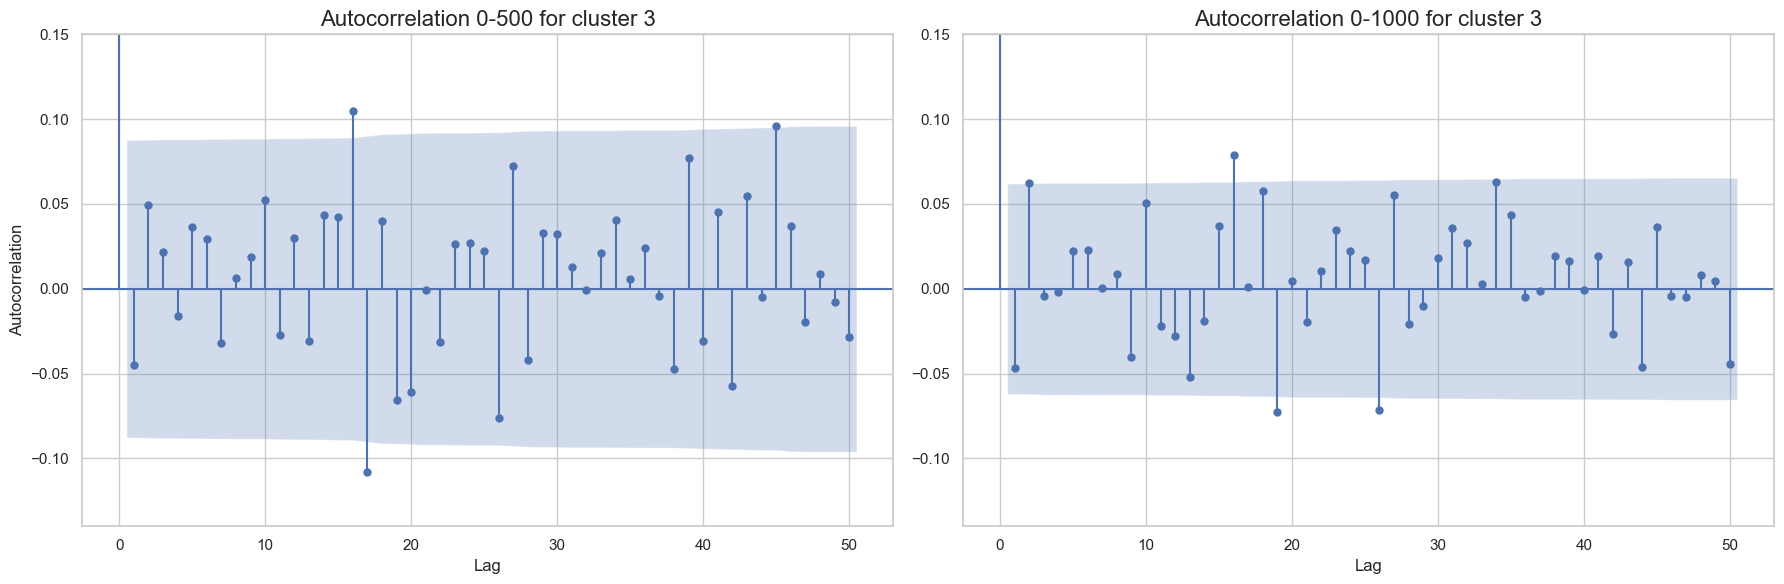

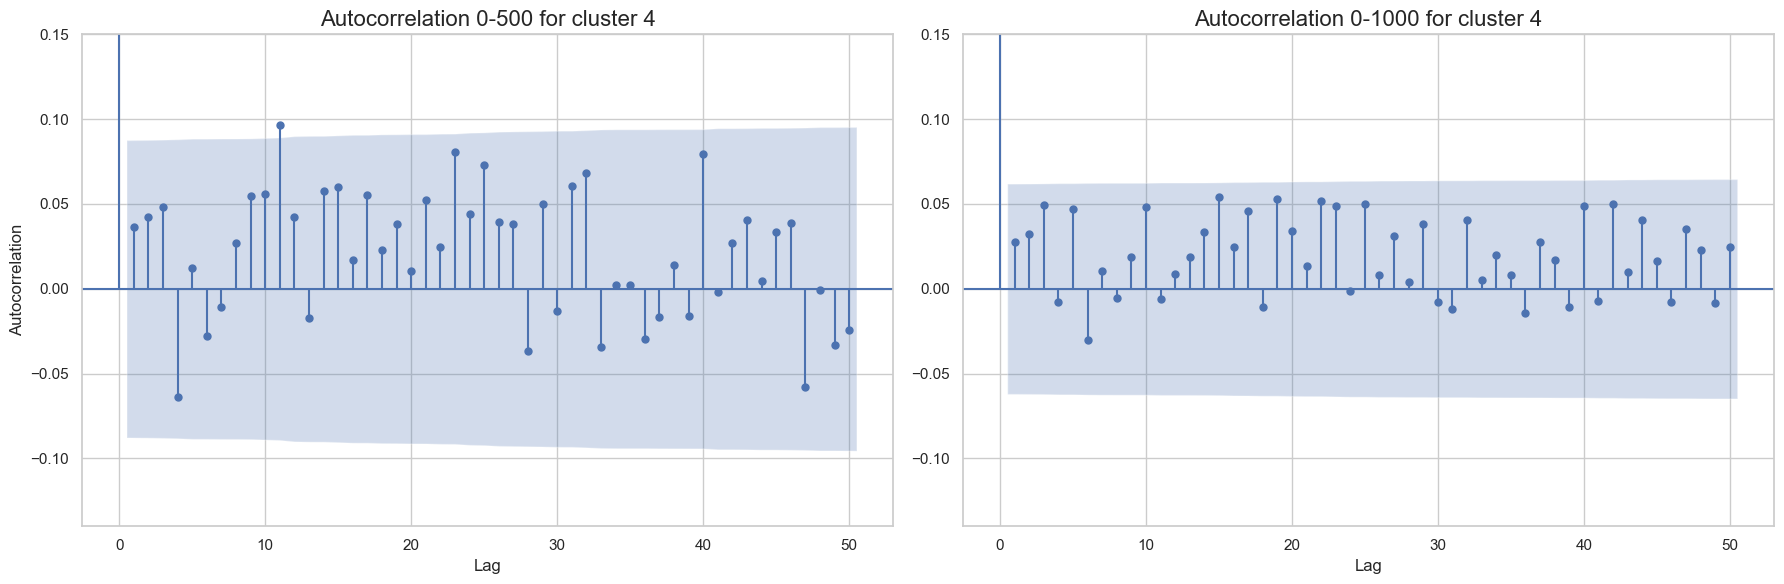

In [545]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Assuming clusters_over_time is a dictionary with values as lists of clusters
# Example: clusters_over_time = {0: [cluster0, cluster1, cluster2, ...], 1: [cluster0, cluster1, cluster2, ...], ...}

# Number of clusters to plot
num_clusters = 5

# Create subplots for each cluster
for i in range(num_clusters):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Autocorrelation Plot for the first half (0-500)
    plot_acf([c[i] for c in clusters_over_time.values[:500]], lags=50, ax=axes[0], alpha=0.05)
    axes[0].set_title(f"Autocorrelation 0-500 for cluster {i}", fontsize=16)
    axes[0].set_xlabel('Lag', fontsize=12)
    axes[0].set_ylabel('Autocorrelation', fontsize=12)
    axes[0].set_ylim(-0.14, 0.15)

    # Autocorrelation Plot for the second half (500-1000)
    plot_acf([c[i] for c in clusters_over_time.values], lags=50, ax=axes[1], alpha=0.05)
    axes[1].set_title(f"Autocorrelation 0-1000 for cluster {i}", fontsize=16)
    axes[1].set_xlabel('Lag', fontsize=12)
    axes[1].set_ylim(-0.14, 0.15)

    plt.tight_layout()
    plt.show()


In [241]:
clusters2_cleaned_new= clean_clusters(clusters2,cluster_assignments,processd_df)

In [ ]:
# Define geographical boundaries and time window
area_bounds = (39.0, 41.0, 115.0, 117.0)  # (min_lat, max_lat, min_lon, max_lon)
prediction_start_time = pd.to_datetime('2008-01-01 00:00:00')
prediction_end_time = pd.to_datetime('2008-12-29 19:00:00')

# Call the prediction function with constraints
predicted_df = predict_future_movements_binned(
    processd_df,
    cluster_assignments,
    clusters2_cleaned_new,
    delta_t_hours=1,
    decimal_places=4,
    area_bounds=area_bounds,
    prediction_start_time=prediction_start_time,
    prediction_end_time=prediction_end_time
)


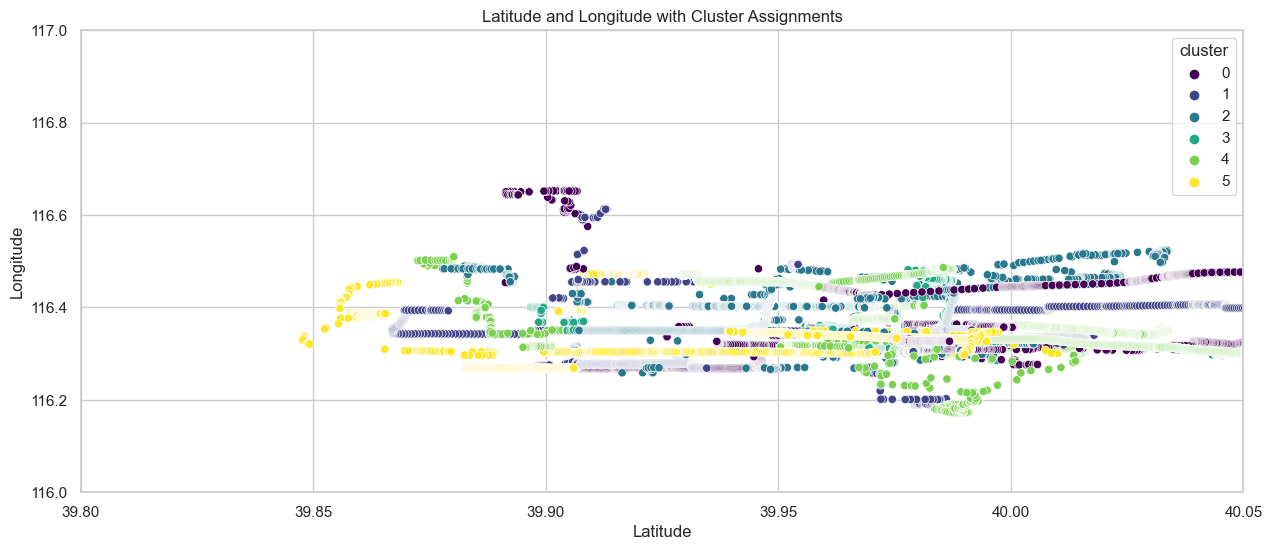

In [593]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'a' is a dictionary of user_id -> cluster assignment
locations_subset = locations_df_new2_assigned_subset.copy()
locations_subset['cluster'] = locations_subset['user_id'].map(cluster_assignments)
# Set the figure size
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")
min_lat, max_lat = 39.5, 40.05    # Latitude range
min_lon, max_lon = 116.00, 117.00
plt.ylim(116,117)
#plt.xlim(39.8,40.2)
plt.xlim(39.8, 40.05)


# Plot the data.
sns.scatterplot(x='origin_lat', y='origin_lon', data= locations_subset,
                hue='cluster', palette='viridis', legend='full')

# Add plot title and labels
plt.title('Latitude and Longitude with Cluster Assignments')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show the plot
plt.show()


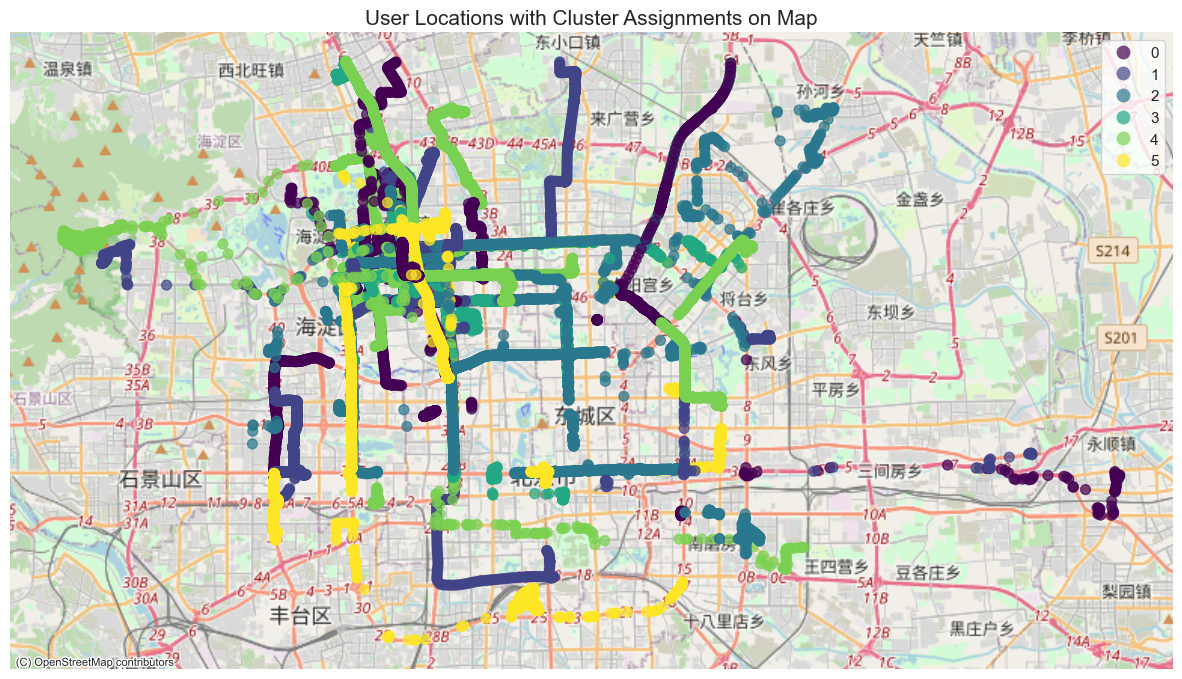

In [594]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import pandas as pd
import seaborn as sns

# Assuming 'locations_df_new2_assigned_subset' is your DataFrame
# and 'cluster_assignments' is a dictionary of user_id -> cluster assignment
locations_subset = locations_df_new2_assigned_subset.copy()
locations_subset['cluster'] = locations_subset['user_id'].map(cluster_assignments)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    locations_subset, 
    geometry=gpd.points_from_xy(locations_subset['origin_lon'], locations_subset['origin_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
)

# Convert to Web Mercator projection (required for contextily)
gdf = gdf.to_crs(epsg=3857)

# Define your specific geographic bounds
min_lat, max_lat = 39.5, 40.05    # Latitude range
min_lon, max_lon = 116.00, 117.00

# Filter the GeoDataFrame based on bounds
gdf_filtered = gdf[
    (gdf['origin_lat'] >= min_lat) & (gdf['origin_lat'] <= max_lat) &
    (gdf['origin_lon'] >= min_lon) & (gdf['origin_lon'] <= max_lon)
]

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style("whitegrid")

# Plot the filtered data
gdf_filtered.plot(
    ax=ax, 
    column='cluster', 
    categorical=True, 
    legend=True, 
    cmap='viridis', 
    markersize=50, 
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Remove axis
ax.set_axis_off()

# Add plot title
plt.title('User Locations with Cluster Assignments on Map', fontsize=15)

# Show the plot
plt.show()


*Clustering phase*

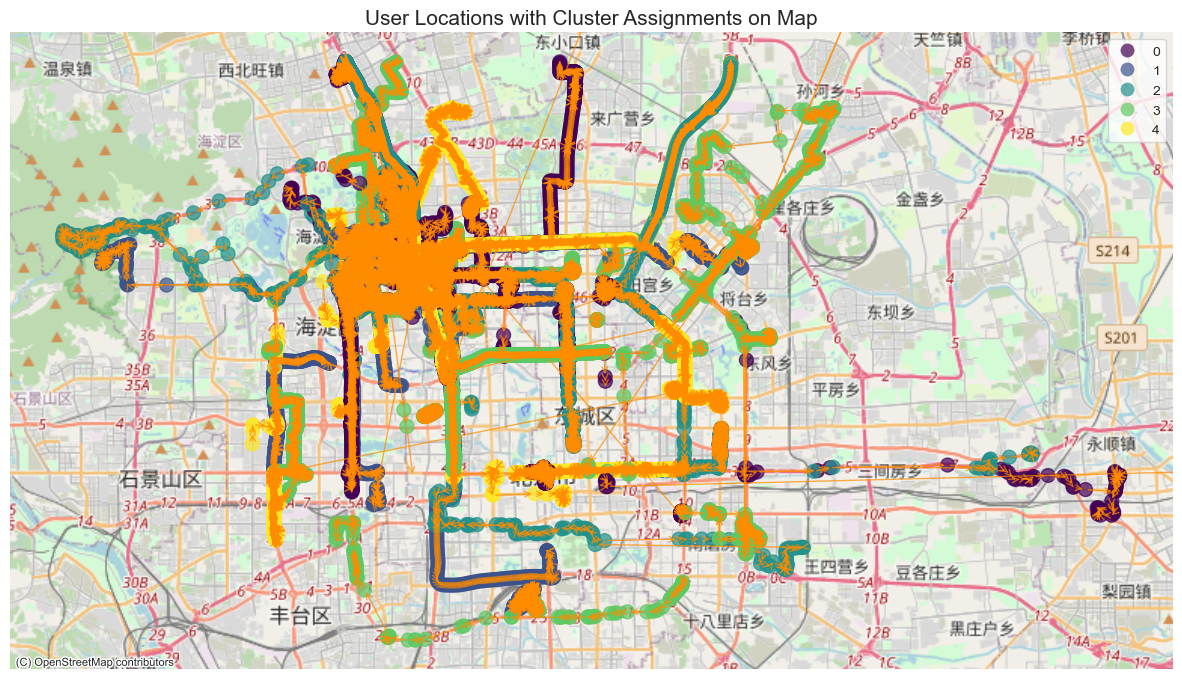

In [152]:
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import FancyArrowPatch

# Assuming 'locations_df_new2_assigned_subset' is your DataFrame
# and 'cluster_assignments' is a dictionary of user_id -> cluster assignment
locations_subset = locations_df_new2_assigned_subset.copy()
locations_subset['cluster'] = locations_subset['user_id'].map(cluster_assignments)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    locations_subset, 
    geometry=gpd.points_from_xy(locations_subset['origin_lon'], locations_subset['origin_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
)

# Convert to Web Mercator projection (required for contextily)
gdf = gdf.to_crs(epsg=3857)

# Define your specific geographic bounds
min_lat, max_lat = 39.5, 40.05    # Latitude range
min_lon, max_lon = 116.00, 117.00

# Filter the GeoDataFrame based on bounds
gdf_filtered = gdf[
    (gdf['origin_lat'] >= min_lat) & (gdf['origin_lat'] <= max_lat) &
    (gdf['origin_lon'] >= min_lon) & (gdf['origin_lon'] <= max_lon)
]

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_style("whitegrid")

# Plot the filtered data
gdf_filtered.plot(
    ax=ax, 
    column='cluster', 
    categorical=True, 
    legend=True, 
    cmap='viridis', 
    markersize=100, 
    alpha=0.7
)
gdf_filtered = gdf_filtered.copy()

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

gdf_filtered['destination_lon'] = gdf_filtered['destination_lon']
gdf_filtered['destination_lat'] = gdf_filtered['destination_lat']

gdf_filtered['destination_geometry'] = gpd.points_from_xy(
    gdf_filtered['destination_lon'], 
    gdf_filtered['destination_lat'],
    crs='EPSG:4326'
).to_crs(epsg=3857)

gdf_filtered['destination_x'] = gdf_filtered['destination_geometry'].x
gdf_filtered['destination_y'] = gdf_filtered['destination_geometry'].y

gdf_filtered['delta_x'] = gdf_filtered['destination_x'] - gdf_filtered.geometry.x
gdf_filtered['delta_y'] = gdf_filtered['destination_y'] - gdf_filtered.geometry.y


average_delta = gdf_filtered[['delta_x', 'delta_y']].abs().mean().mean()

# Adjust arrow_scale based on average_delta
# You may need to tweak this multiplier based on your specific data
arrow_scale = average_delta * 1000  # Increase multiplier if arrows are too short
arrow_width = 0.001  
"""
ax.quiver(
    gdf_filtered.geometry.x, 
    gdf_filtered.geometry.y, 
    gdf_filtered['delta_x'], 
    gdf_filtered['delta_y'],
    angles='xy',
    scale_units='xy',
    scale=arrow_scale,
    width=arrow_width,
    color='red',
    alpha=0.5,
    label='Actual Direction'
)
"""
for idx, row in gdf_filtered.iterrows():
    arrow = FancyArrowPatch(
        (row.geometry.x + 0.001, row.geometry.y + 0.001),
        (row.destination_x + 0.001, row.destination_y + 0.001),
        arrowstyle='->',
        mutation_scale=10,
        color='darkorange',
        alpha=0.7
    )
    ax.add_patch(arrow)
actual_marker = mpatches.Patch(color='blue', label='Actual Movements')
actual_arrow = Line2D([0], [0], color='blue', lw=2, label='Actual Direction')

# Remove axis
ax.set_axis_off()

# Add plot title
plt.title('User Locations with Cluster Assignments on Map', fontsize=15)

# Show the plot
plt.show()



*Directions of Displacements*

In [ ]:
"""
import folium
import geopandas as gpd
import pandas as pd
import branca

# Assuming 'locations_df_new2_assigned_subset' is your DataFrame
# and 'cluster_assignments' is a dictionary of user_id -> cluster assignment

# Copy and map cluster assignments
locations_subset = locations_df_new2_assigned_subset.copy()
locations_subset['cluster'] = locations_subset['user_id'].map(cluster_assignments)

# Create a GeoDataFrame in EPSG:4326
gdf = gpd.GeoDataFrame(
    locations_subset, 
    geometry=gpd.points_from_xy(locations_subset['origin_lon'], locations_subset['origin_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
)

# Define your specific geographic bounds
min_lat, max_lat = 39.5, 40.05    # Latitude range
min_lon, max_lon = 116.00, 117.00  # Longitude range

# Filter the GeoDataFrame based on bounds
gdf_filtered = gdf[
    (gdf['origin_lat'] >= min_lat) & (gdf['origin_lat'] <= max_lat) &
    (gdf['origin_lon'] >= min_lon) & (gdf['origin_lon'] <= max_lon)
]

# Identify unique clusters
unique_clusters = gdf_filtered['cluster'].unique()

# Create a color palette
colormap = branca.colormap.linear.Set1_09.scale(0, len(unique_clusters)).to_step(len(unique_clusters))

# Map each cluster to a color
cluster_color_dict = {cluster: colormap(i) for i, cluster in enumerate(unique_clusters)}

# Calculate the center of the map
mean_lat = gdf_filtered['origin_lat'].mean()
mean_lon = gdf_filtered['origin_lon'].mean()

# Initialize the Folium map
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=10, tiles='CartoDB positron')

# Iterate through the filtered GeoDataFrame and add markers
for idx, row in gdf_filtered.iterrows():
    folium.CircleMarker(
        location=[row['origin_lat'], row['origin_lon']],
        radius=5,  # Adjust marker size as needed
        color=cluster_color_dict[row['cluster']],
        fill=True,
        fill_color=cluster_color_dict[row['cluster']],
        fill_opacity=0.7,
        popup=f"User ID: {row['user_id']}<br>Cluster: {row['cluster']}"
    ).add_to(m)

# Add the colormap (legend) to the map
colormap.caption = 'Cluster Colors'
colormap.add_to(m)

# Save the map to an HTML file
m.save('user_locations_map.html')

# Display the map in a Jupyter Notebook (if applicable)
m
"""

In [ ]:
"""
import folium
from folium import plugins

# Convert GeoDataFrames back to EPSG:4326 for folium
gdf_actual = gpd.GeoDataFrame(
    locations_df_new2_assigned_subset,
    geometry=gpd.points_from_xy(locations_df_new2_assigned_rest_subset['origin_lon'], locations_df_new2_assigned_rest_subset['origin_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
).to_crs(epsg=3857)  # Convert to Web Mercator

gdf_predicted = gpd.GeoDataFrame(
    predicted_df, 
    geometry=gpd.points_from_xy(predicted_df['predicted_lon'], predicted_df['predicted_lat']),
    crs='EPSG:4326').to_crs(epsg=3857)


gdf_actual_wgs84 = gdf_actual.to_crs(epsg=4326)
gdf_predicted_wgs84 = gdf_predicted.to_crs(epsg=4326)

# Initialize the map centered around your bounds
m = folium.Map(location=[(min_lat + max_lat)/2, (min_lon + max_lon)/2], zoom_start=6)

# Add Actual Movements
for idx, row in gdf_actual_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='salmon',
        fill=True,
        fill_color='salmon',
        legend = 'Actual Movements',
        fill_opacity=0.7,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)

# Add Predicted Movements
for idx, row in gdf_predicted_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='violet',
        fill=True,
        fill_color='violet',
        legend = 'Predicted Movements',
        fill_opacity=1,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)
# add legend


# Save or display the map
m.save('user_movements_map.html')
display(m)
"""


In [743]:
#Original data without subset

locations_df_new2_assigned_rest = locations_df_new2_assigned.drop(locations_df_new2_assigned_subset.index)
#get last 100 movements for each user

locations_df_new2_assigned_rest_subset = locations_df_new2_assigned_rest.groupby('user_id').head(400)
#locations_df_new2_assigned_rest_subset = locations_df_new2_assigned_rest.groupby('user_id').head(400)
locations_df_new2_assigned_rest_subset['end_time'] = pd.to_datetime(locations_df_new2_assigned_rest_subset['end_time'])
locations_df_new2_assigned_rest_subset['start_time'] = pd.to_datetime(locations_df_new2_assigned_rest_subset['start_time'])
locations_df_new2_assigned_rest_subset = locations_df_new2_assigned_rest_subset[locations_df_new2_assigned_rest_subset['start_time'].dt.year == 2008]

In [ ]:
predicted_df[(predicted_df['predicted_time'].dt.month == 10) & (predicted_df['predicted_time'].dt.year == 2008) &
              (predicted_df['predicted_time'].dt.day == 24) & (predicted_df['predicted_time'].dt.hour <= 11) &
                (predicted_df['predicted_time'].dt.minute <= 49)]

In [ ]:
locations_df_new2_assigned_rest_subset['end_time'] = pd.to_datetime(locations_df_new2_assigned_rest_subset['end_time'])
locations_df_new2_assigned_rest_subset[(locations_df_new2_assigned_rest_subset['end_time'].dt.month == 10) & 
                                       (locations_df_new2_assigned_rest_subset['end_time'].dt.year == 2008) &
                                         (locations_df_new2_assigned_rest_subset['end_time'].dt.day == 24)]

In [ ]:
"""
# Plot predicted movements to actual movements

import matplotlib.pyplot as plt
# Create a figure and axis
plt.figure(figsize=(10, 8))

#more than 40 rows in user_id
predict_more_than_40 = predicted_df['user_id'].value_counts()[predicted_df['user_id'].value_counts() > 40].index
actual_users = locations_df_new2_assigned_rest_subset['user_id'].value_counts()[locations_df_new2_assigned_rest_subset['user_id'].value_counts() > 40].index
predicted_users = locations_df_new2_assigned_rest_subset['user_id'][locations_df_new2_assigned_rest_subset['user_id'].isin(predict_more_than_40)].unique()

#Same time:



# Plot actual destinations
sns.scatterplot(x='origin_lat', y='origin_lon', data= locations_df_new2_assigned_rest_subset[locations_df_new2_assigned_rest_subset['user_id'].isin(predicted_users)], #hue = 'user_id',palette= 'Set1'
                 legend='full',  alpha=0.5, label='Actual Movements', s=10)

#set colors
sns.set_palette("Set1")

# Plot predicted movements
sns.scatterplot(x='predicted_lat', y='predicted_lon', data=predicted_df[predicted_df['user_id'].isin(predicted_users)], #hue='user_id', palette= 'Set2', 
                legend='full',
                alpha=0.5, label='Predicted Movements', s=10)


plt.xlim(39.95, 40.1)
plt.ylim(115, 117)

# Add title and labels
plt.title('Actual vs Predicted Movements')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Add legend
plt.legend()

# Show plot
plt.show()
"""



In [ ]:
import folium
from folium import plugins

# Convert GeoDataFrames back to EPSG:4326 for folium
gdf_actual = gpd.GeoDataFrame(
    locations_df_new2_assigned_rest_subset, 
    geometry=gpd.points_from_xy(locations_df_new2_assigned_rest_subset['destination_lon'], locations_df_new2_assigned_rest_subset['destination_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
).to_crs(epsg=3857)  # Convert to Web Mercator

gdf_predicted = gpd.GeoDataFrame(
    predicted_df, 
    geometry=gpd.points_from_xy(predicted_df['predicted_lon'], predicted_df['predicted_lat']),
    crs='EPSG:4326').to_crs(epsg=3857)


gdf_actual_wgs84 = gdf_actual.to_crs(epsg=4326)
gdf_predicted_wgs84 = gdf_predicted.to_crs(epsg=4326)

# Initialize the map centered around your bounds
m = folium.Map(location=[(min_lat + max_lat)/2, (min_lon + max_lon)/2], zoom_start=6)

# Add Actual Movements
for idx, row in gdf_actual_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='salmon',
        fill=True,
        fill_color='salmon',
        legend = 'Actual Movements',
        fill_opacity=0.7,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)

# Add Predicted Movements
for idx, row in gdf_predicted_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='violet',
        fill=True,
        fill_color='violet',
        legend = 'Predicted Movements',
        fill_opacity=1,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)
# add legend


# Save or display the map
m.save('user_movements_map.html')
display(m)


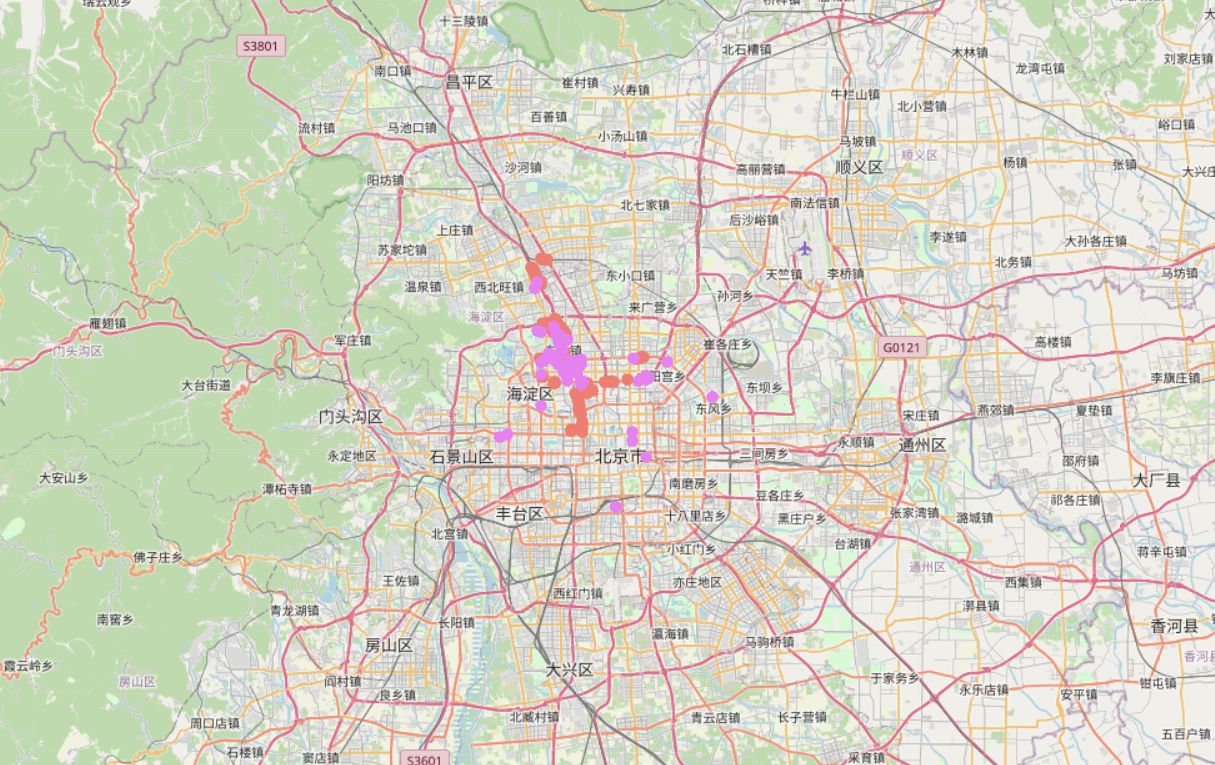

*Predicting for 2008*

In [ ]:
import folium
from folium import plugins
a = locations_df_new2_assigned_rest_subset[(locations_df_new2_assigned_rest_subset['end_time'].dt.month == 10) & 
                                       (locations_df_new2_assigned_rest_subset['end_time'].dt.year == 2008) &
                                         (locations_df_new2_assigned_rest_subset['end_time'].dt.day == 24)]
b = predicted_df[(predicted_df['predicted_time'].dt.month == 10) & (predicted_df['predicted_time'].dt.year == 2008) &
              (predicted_df['predicted_time'].dt.day == 24) & (predicted_df['predicted_time'].dt.hour <=11) &
                (predicted_df['predicted_time'].dt.minute <= 49)]
# Convert GeoDataFrames back to EPSG:4326 for folium
gdf_actual = gpd.GeoDataFrame(
    a, 
    geometry=gpd.points_from_xy(a['destination_lon'], a['destination_lat']),
    crs='EPSG:4326'  # WGS84 Latitude/Longitude
).to_crs(epsg=3857)  # Convert to Web Mercator

gdf_predicted = gpd.GeoDataFrame(
    b, 
    geometry=gpd.points_from_xy(b['predicted_lon'], b['predicted_lat']),
    crs='EPSG:4326').to_crs(epsg=3857)


gdf_actual_wgs84 = gdf_actual.to_crs(epsg=4326)
gdf_predicted_wgs84 = gdf_predicted.to_crs(epsg=4326)

# Initialize the map centered around your bounds
m = folium.Map(location=[(min_lat + max_lat)/2, (min_lon + max_lon)/2], zoom_start=6)

# Add Actual Movements
for idx, row in gdf_actual_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='salmon',
        fill=True,
        fill_color='salmon',
        legend = 'Actual Movements',
        fill_opacity=0.7,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)

# Add Predicted Movements
for idx, row in gdf_predicted_wgs84.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=3,
        color='violet',
        fill=True,
        fill_color='violet',
        legend = 'Predicted Movements',
        fill_opacity=1,
        popup=f"User ID: {row['user_id']}"  # Customize as needed
    ).add_to(m)
# add legend


# Save or display the map
m.save('user_movements_map.html')
display(m)


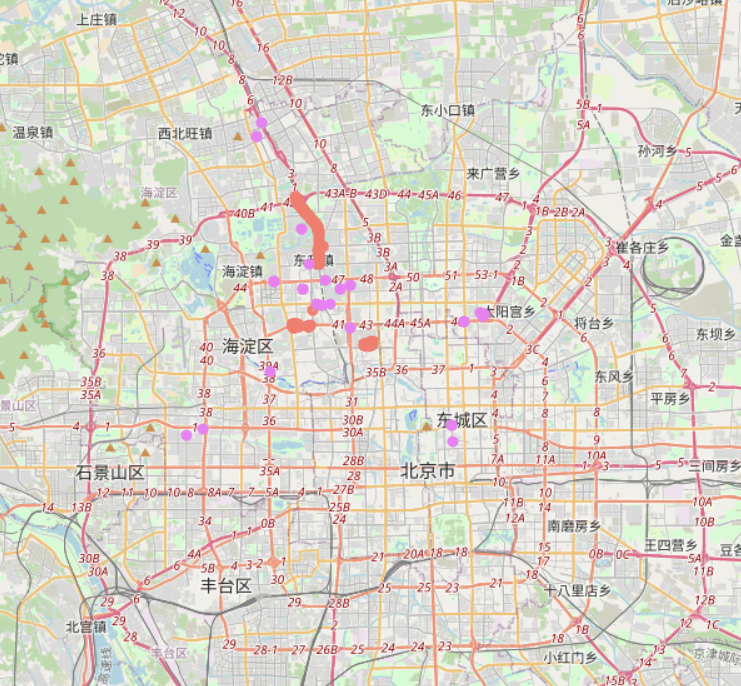

*Predicting for 10.24.08* 

(0.0, 0.3)

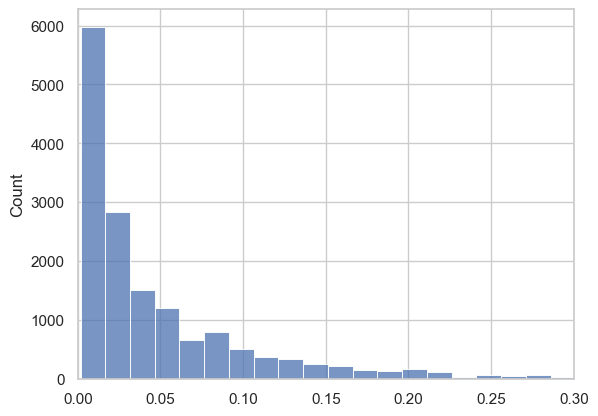

In [550]:
sns.histplot(log_lik,bins=50)
plt.xlim(0,0.3)

*Likelihood plot*

<Axes: ylabel='Count'>

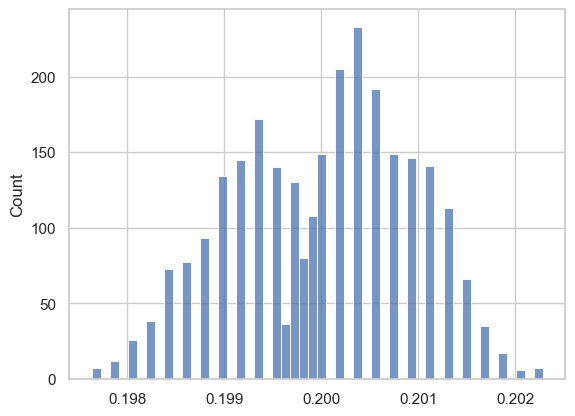

In [549]:
sns.histplot(log_p,bins=50)

*Prior Plot*

## Cross validation

In [ ]:
# Define hyperparameter grid
gamma_values = [0.1, 1, 10]
alpha_values = [0.001, 0.01, 0.1]
beta_values = [100, 1000, 10000]
num_clusters_values = [3, 5, 7]

best_score = -1
best_params = {}

for gamma in gamma_values:
    for alpha in alpha_values:
        for beta in beta_values:
            for num_clusters in num_clusters_values:
                # Perform clustering with current hyperparameters
                cluster_assignments, _, _, _, _, _ = gibbs_sampling_over_time(
                    locations_df_new2_assigned_subset,
                    num_clusters=num_clusters,
                    num_iterations=num_iterations,
                    gamma=gamma,
                    alpha=alpha,
                    beta=beta,
                    speed_thresholds=speed_thresholds,
                    delta_time_hours=delta_time_hours,
                    decimal_places=4
                )
                
                # Prepare data and labels
                cluster_labels = np.array([cluster_assignments[user_id] for user_id in processd_df['user_id']])
                data = processd_df[['origin_lat', 'origin_lon']].values
                
                # Compute evaluation metric
                sil_score = silhouette_score(data, cluster_labels, metric='euclidean')
                
                # Update best score and parameters
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {
                        'gamma': gamma,
                        'alpha': alpha,
                        'beta': beta,
                        'num_clusters': num_clusters
                    }

print(f"Best Silhouette Score: {best_score:.4f}")
print(f"Best Hyperparameters: {best_params}")
